In [ ]:
!pip install zenodo-get

!zenodo_get 10.5281/zenodo.7711810 -g "EuroSAT_RGB.zip"

Title: EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification
Keywords: remote sensing, earth observation, land cover classification, land use classification, satellite images, sentinel-2, machine learning, deep learning, deep convolutional neural network
Publication date: 2018-07-22
DOI: 10.5281/zenodo.7711810
Total size: 94.7 MB

File: EuroSAT_RGB.zip (94.7 MB)
Link: https://zenodo.org/api/records/7711810/files/EuroSAT_RGB.zip/content
EuroSAT_RGB.zip is already downloaded correctly.

All specified files have been processed.


In [ ]:
import zipfile
import os

# Define the path to your zip file
zip_file_path = './EuroSAT_RGB.zip'


extract_to_directory = 'extracted_files'

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_directory)
    print(f"Successfully extracted all contents of '{zip_file_path}' to '{extract_to_directory}'")
except zipfile.BadZipFile:
    print(f"Error: '{zip_file_path}' is not a valid zip file.")
except FileNotFoundError:
    print(f"Error: Zip file '{zip_file_path}' not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully extracted all contents of './EuroSAT_RGB.zip' to 'extracted_files'


In [ ]:
import os
from sklearn.model_selection import train_test_split

# Gather all image file paths
image_dir = './extracted_files/EuroSAT_RGB/'
all_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]

all_files = []
labels = []

for path in all_paths:
  all_files.extend([os.path.join(path, f) for f in os.listdir(path)])
  index = path.find('EuroSAT_RGB/')
  if index != -1:
      start_index = index + len('EuroSAT_RGB/')
      result = path[start_index:]
  else:
      result = "" # Target string not found
  labels.extend([result] * len(os.listdir(path)))

# Get labels (assuming class names are part of the file paths)
labels = [os.path.basename(os.path.dirname(f)) for f in all_files]


from sklearn.preprocessing import LabelEncoder
import torch
import numpy as np

# Example categorical data
categories = np.unique(labels)

# Initialize and fit LabelEncoder
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Convert to PyTorch tensor
encoded_tensor = torch.tensor(encoded_labels, dtype=torch.long)

print(f"Original categories: {categories}")
print(f"Encoded labels: {encoded_labels}")
print(f"PyTorch tensor: {encoded_tensor}")


Original categories: ['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']
Encoded labels: [1 1 1 ... 5 5 5]
PyTorch tensor: tensor([1, 1, 1,  ..., 5, 5, 5])


In [ ]:
from PIL import Image
import numpy as np

# Load the image
# Replace 'path/to/your/image.jpg' with the actual path to your image file
image = Image.open('./extracted_files/EuroSAT_RGB/HerbaceousVegetation/HerbaceousVegetation_1.jpg')

# Convert the image to a NumPy array
# For grayscale images, the array will be 2D (height, width)
# For color images (RGB), the array will be 3D (height, width, 3)
image_array = np.asarray(image)

# Print the type and shape of the resulting NumPy array
print(f"Type of image_array: {type(image_array)}")
print(f"Shape of image_array: {image_array.shape}")

Type of image_array: <class 'numpy.ndarray'>
Shape of image_array: (64, 64, 3)


Begin github code

In [ ]:
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms


transform = transforms.Compose([transforms.ToTensor()])          # Convert PIL Image to PyTorch Tensor])

train_dataset = ImageFolder(root='./extracted_files/EuroSAT_RGB', transform=transform)
test_dataset = ImageFolder(root='./extracted_files/EuroSAT_RGB', transform=transform)



In [ ]:
from torch.utils.data import DataLoader
batch_size = 10

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,  # Adjust batch size as needed
    shuffle=False,  # No need to shuffle for testing
    num_workers=1   # Number of subprocesses to use for data loading (adjust based on system)
    )

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch

# Load the full dataset
full_dataset = ImageFolder(root='./extracted_files/EuroSAT_RGB', transform=transform)

# Get all indices and their corresponding labels
indices = list(range(len(full_dataset)))
labels = full_dataset.targets  # ImageFolder stores class labels here

# Stratified split: 80% train, 20% test
train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42  # for reproducibility
)

# create subsets
train_dataset = Subset(full_dataset, train_idx)
test_dataset = Subset(full_dataset, test_idx)

# specify device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,   # shuffle during training
    num_workers=1,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
)


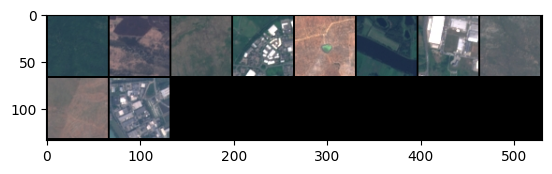

10
Forest HerbaceousVegetation HerbaceousVegetation Industrial PermanentCrop River Industrial HerbaceousVegetation HerbaceousVegetation Industrial


In [ ]:
# functions to show an image
import matplotlib.pyplot as plt

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
#print(images.shape)
#print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))
print(len(categories))

# print labels
print(' '.join(f'{categories[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # 8x8x3 input image
        # Layer 1: Conv -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Output size after conv1 with padding: 64x64x16
        # Output size after maxpool (2x2 kernel): 32x32x16

        # Layer 2: Conv -> ReLU -> MaxPool
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Output size after conv2 with padding: 32x32x32
        # Output size after maxpool (2x2 kernel): 16x16x32

        # Fully connected layers

        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)


        # Flatten for fully connected layers
        x = x.view(-1, 32 * 16 * 16)


        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Create an instance of the model
model = SimpleCNN(num_classes=10)
print(model)

# Create a dummy input tensor for an 8x8x3 image
# PyTorch expects input in the format [batch_size, channels, height, width]
#dummy_input = torch.randn(1, 3, 8, 8)

# Create an instance of the model
model = SimpleCNN(num_classes=10)
model.to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(100):  # loop over the dataset multiple times
    print('Epoch ', epoch-1, 'finished')
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

Epoch  -1 finished
[1,     1] loss: 0.023
Epoch  0 finished
[2,     1] loss: 0.022
Epoch  1 finished
[3,     1] loss: 0.021
Epoch  2 finished
[4,     1] loss: 0.020
Epoch  3 finished
[5,     1] loss: 0.019
Epoch  4 finished
[6,     1] loss: 0.018
Epoch  5 finished
[7,     1] loss: 0.017
Epoch  6 finished
[8,     1] loss: 0.016
Epoch  7 finished
[9,     1] loss: 0.016
Epoch  8 finished
[10,     1] loss: 0.015
Epoch  9 finished
[11,     1] loss: 0.015
Epoch  10 finished
[12,     1] loss: 0.015
Epoch  11 finished


KeyboardInterrupt: 

In [ ]:
PATH = './image_net.pth'
torch.save(model.state_dict(), PATH)

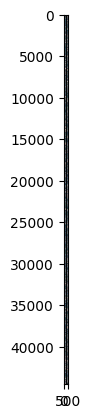

GroundTruth:  AnnualCrop Industrial AnnualCrop Forest


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{categories[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = SimpleCNN()
net.load_state_dict(torch.load(PATH, weights_only=True))



<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{categories[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  SeaLake PermanentCrop Forest Residential


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 44 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in categories}
total_pred = {classname: 0 for classname in categories}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[categories[label]] += 1
            total_pred[categories[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: AnnualCrop is 61.7 %
Accuracy for class: Forest is 87.5 %
Accuracy for class: HerbaceousVegetation is 28.7 %
Accuracy for class: Highway is 26.2 %
Accuracy for class: Industrial is 69.8 %
Accuracy for class: Pasture is 6.0 %
Accuracy for class: PermanentCrop is 33.2 %
Accuracy for class: Residential is 78.2 %
Accuracy for class: River is 28.8 %
Accuracy for class: SeaLake is 11.8 %
